based on https://arxiv.org/pdf/1611.01578.pdf

at every step, the RNN outputs two vectors, representing probability distributions for
 - type of layer: can be fully connected, skip connection, dropout, or end of network
 - argument for the layer: can be dropout probability, number of layers to skip (backwards), or number of neurons

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [15]:
class ControllerRNN:
    def __init__(self):
        self.rnn_size = 32
        self.unroll_by = 10
        self.batch_size = 5
        self.learning_rate = 0.001
        self.type_size = 3
        self.arg_size = 10

    def build(self):
        # reward for the architectures
        self.architecture_reward = tf.placeholder(tf.float32, [self.batch_size])
        
        # exponential moving average of the reward
        self.last_average_reward = tf.reduce_mean(self.architecture_reward)
        self.reward_ema = tf.train.ExponentialMovingAverage(0.99)
        self.update_reward_ema = self.reward_ema.apply([self.last_average_reward])

        rnn = tf.contrib.rnn.GRUCell(self.rnn_size)
        state = tf.random_normal([self.batch_size, rnn.state_size])
        
        # weight matrices to transform from rnn output to layer type and discrete arg
        rnn_to_layer_type_weight = tf.Variable(tf.random_normal([rnn.output_size, self.type_size]))
        rnn_to_layer_type_gradient = []
        rnn_to_layer_arg_weight = tf.Variable(tf.random_normal([rnn.output_size, self.arg_size]))
        rnn_to_layer_arg_gradient = []

        # rnn output and gradients
        output = tf.random_normal([self.batch_size, rnn.output_size])

        # layer_probs contains the output from the network, namely the probabilities
        # of type and argument for every layer of every network
        self.layer_probs = []

        # layer_indicators contains one-hot indicators of type and argument
        # for every layer of every network.
        # used to select which action is used to compute the gradient.
        # fixed, must be set before updating the weights
        self.layer_indicators = []

        for i in range(self.unroll_by):
            # run rnn cell
            output, state = rnn(output, state)

            if i == 0:  # gru variables are only initialized now
                rnn_params = rnn.trainable_variables + rnn.trainable_weights
                rnn_gradients = [[] for _ in range(len(rnn_params))]

            # compute output probabilites
            layer_type = tf.nn.softmax(tf.matmul(output, rnn_to_layer_type_weight))
            layer_arg = tf.nn.softmax(tf.matmul(output, rnn_to_layer_arg_weight))
            chosen_layer_type = tf.placeholder(tf.int32, self.batch_size)
            chosen_layer_arg = tf.placeholder(tf.int32, self.batch_size)
            self.layer_probs.append((layer_type, layer_arg))
            self.layer_indicators.append((chosen_layer_type, chosen_layer_arg))

            # aggregate gradients
            baseline = self.reward_ema.average(self.last_average_reward)
            prob = (self.last_average_reward - baseline) * (
                tf.reduce_sum(
                    tf.one_hot(chosen_layer_type, depth=self.type_size) * tf.log(layer_type + 1e-12),
                    axis=1
                ) + tf.reduce_sum(
                    tf.one_hot(chosen_layer_arg, depth=self.arg_size) * tf.log(layer_arg + 1e-12),
                    axis=1
                )
            )

            rnn_to_layer_arg_gradient.append(tf.gradients(prob, rnn_to_layer_arg_weight)[0])
            rnn_to_layer_type_gradient.append(tf.gradients(prob, rnn_to_layer_type_weight)[0])
            for param, grad in zip(rnn_params, rnn_gradients):
                grad.append(tf.gradients(prob, param)[0])

        def sanitize_gradient(grads):
            avg = sum(grads) / len(grads)
            return tf.clip_by_norm(avg, 1.0)

        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.optimize = optimizer.apply_gradients([
            (sanitize_gradient(grad), param)
            for param, grad in zip(rnn_params, rnn_gradients)
        ] + [
            (sanitize_gradient(rnn_to_layer_type_gradient), rnn_to_layer_type_weight),
            (sanitize_gradient(rnn_to_layer_arg_gradient), rnn_to_layer_arg_weight),
        ])

    def generate_architecture(self, session):
        layers = session.run(self.layer_probs)
        networks = [[] for _ in range(self.batch_size)]
        for (ltype, larg) in layers:
            for i, (nnet, type_prob, arg_prob) in enumerate(zip(networks, ltype, larg)):
                # the network always has at least one layer
                if nnet and nnet[-1][0] == 0:
                    continue

                assert all(np.isfinite(type_prob))
                assert all(np.isfinite(arg_prob))

                layer_type = np.random.choice(len(type_prob), p=type_prob)
                layer_arg = np.random.choice(len(arg_prob), p=arg_prob)
                nnet.append((layer_type, layer_arg))

        return networks

    def learn_from_rewards(self, sess, networks, rewards):
        assert len(rewards) == self.batch_size

        # set the indicator variables, telling which action was chosen
        feed_dict = {ind: []
                     for layer_ind in self.layer_indicators
                     for ind in layer_ind}

        for nnet in networks:
            # pad network if shorter than expected
            # we set the indicators to -1, so that all one hot will be 0
            # thus not contributing to the gradient
            if len(nnet) < self.unroll_by:
                nnet = nnet + [(-1, -1)] * (self.unroll_by - len(nnet))

            assert len(nnet) == self.unroll_by
            for (itype, iarg), (ntype, narg) in zip(self.layer_indicators, nnet):
                feed_dict[itype].append(ntype)
                feed_dict[iarg].append(narg)

        feed_dict[self.architecture_reward] = rewards
        sess.run([self.update_reward_ema, self.optimize], feed_dict=feed_dict)

we can test this controller with a very simple and quick task: generate a 4 layer neural network with the following layer arguments: $(4,3,2,1)$ and the following layer types: $(1,2,3,1)$. the goodness of a candidate architecture is simply the mean squared error between it and the target architecture

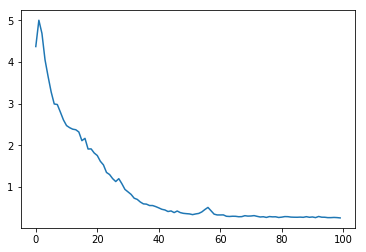

In [16]:
def evaluate_architecture(arch):
    target_depth = 4
    
    target_arch = np.zeros((controller.unroll_by, 2))
    target_arch[:target_depth, 0] = [1 + i % 3 for i in range(target_depth)]
    target_arch[:target_depth, 1] = [target_depth - i + 1 for i in range(target_depth)]

    full_arch = np.zeros((controller.unroll_by, 2))
    full_arch[:len(arch), :] = arch

    return np.mean((full_arch - target_arch)**2)


controller = ControllerRNN()
hist = []
with tf.Graph().as_default():
    controller.build()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        rs = []
        for i in range(10000):
            networks = controller.generate_architecture(sess)
            rewards = list(map(evaluate_architecture, networks))
            controller.learn_from_rewards(sess, networks, rewards)

            rs.extend(rewards)
            if i % 100 == 0:
                hist.append(np.mean(rs))
                print(i, hist[-1])
                rs = []

clear_output()
plt.plot(hist)

awesome

we can try building a real neural network, then! for simplicity, we ignore the layer type, since we test on a very simple problem